# Program to generate figures for the APOGEE halo migrants paper 
# Original submitted version with a S/N cut at 80 instead of 100
# Has been superseded - do not use
# Adding this line to see if I can cause a github conflict by uploading different files with the same name

In [1]:
#import all the things
import numpy as np
import math
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from astropy import units as u
from astropy.table import Table, vstack, join, Column, unique
from astropy.coordinates import Distance, Galactocentric, SkyCoord
import astropy.coordinates as coord
%matplotlib inline

#Set environment: franklin or cannon
#franklin
#path1='/Users/sarah/active/programs/apogee-migrants/'
#cannon
path1='/Users/sarah/active/programs/apogee-migrants/'

/Users/sarah/anaconda/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
#Grab the DR12 data
d1=Table.read(path1+'data/allStar+-v603.150209.fits')
d1=unique(d1,keys='APOGEE_ID')

#Filter DR12 down to halo giants
#Filter 1: aspcapflag of STAR_BAD must not be set
f1=[]
for i in range(len(d1)):
    f1.append('STAR_BAD' in (d1['ASPCAPFLAGS'])[i])
f1c=Column(f1)
d2=d1[np.where(f1c == False)]

#Filter 2: targflags of SCI_CLUSTER and CALIB_CLUSTER must not be set
f2=[]
for i in range(len(d2)):
    f2.append(('SCI_CLUSTER' in (d2['TARGFLAGS'])[i]) or ('CALIB_CLUSTER' in (d2['TARGFLAGS'])[i]))
f2c=Column(f2)
d3=d2[np.where(f2c == False)]

#Filter 3: read in the list from Matthew of stars that are likely unmarked cluster members (there are 32), remove any stars on that list from the table (there are 14)
slist=Table.read('/Users/sarah/active/programs/apogee-migrants/data/GCcontaminants.txt',format='csv')
f3=[]
for i in np.arange(len(d3)):
    f3.append(len((np.where(slist['APOGEE_ID'] == d3['APOGEE_ID'][i]))[0]))
f3=np.array(f3)
d4=d3[np.where(f3 == 0)]

#Filter 4: reasonable values for SNR, d, log(g), Teff, [N/Fe], [Al/Fe], [Fe/H] and RA/DEC coordinates
#First, pull out the values from d4['DISO'] (this is distance) and d4['FPARAM'] (these are uncalibrated parameters) that we need
dvec=[]
loggvec=[]
teffvec=[]
for i in range(len(d4)):
    dvec.append(((d4['DISO'])[i])[1])
    loggvec.append(((d4['FPARAM'])[i])[1])
    teffvec.append(((d4['FPARAM'])[i])[0])
dvec=Column(dvec,name='dist')
loggvec=Column(loggvec,name='logg')
teffvec=Column(teffvec,name='teff')
d4.add_column(dvec)
d4.add_column(loggvec)
d4.add_column(teffvec)

#Next, calculate |z| based on dvec and Galactic latitude
zvec=dvec*np.sin((np.pi*np.absolute(d4['GLAT'])/180))
zvec=Column(zvec,name='z_height')
d4.add_column(zvec)
f4=np.where((d4['SNR'] > 80) & (d4['dist'] > 0) & (d4['logg'] > -9000) & (d4['teff'] > -9000) & (d4['N_H'] < 9000) & (d4['AL_H'] > -9000) & (d4['FE_H'] > -9000) & (d4['RA']>-95) & (d4['DEC']>-95))
d5=d4[f4]

#Filter 5: halo giants only (limits on logg, Fe/H], |z|)
f5=np.where((d5['logg'] < 3) & (d5['FE_H'] < -1) & (d5['FE_H'] > -1.8) & (d5['z_height'] > 10) & (d5['teff'] < 4500))
d6=d5[f5]
#also grab the complement of f5 (that is, d5 without d6)
m5=np.ones(len(d5),np.bool)
m5[f5]=0
d6inv=d5[m5]

#alternate halo criterion: |z|>5 kpc
#f5alt=np.where((d5['logg'] < 3) & (d5['FE_H'] < -1) & (d5['FE_H'] > -1.8) & (d5['z_height'] > 3) & (d5['teff'] < 4500))
#d6alt=d5[f5alt]

In [3]:
#Define some useful new columns
cfe=Column(d6['C_H']-d6['FE_H'],name='cfe')
cfe_err=Column(np.sqrt((d6['C_H_ERR']**2)+(d6['FE_H_ERR']**2)),name='cfe_err')
nfe=Column(d6['N_H']-d6['FE_H'],name='nfe')
nfe_err=Column(np.sqrt((d6['N_H_ERR']**2)+(d6['FE_H_ERR']**2)),name='nfe_err')
alfe=Column(d6['AL_H']-d6['FE_H'],name='alfe')
alfe_err=Column(np.sqrt((d6['AL_H_ERR']**2)+(d6['FE_H_ERR']**2)),name='alfe_err')
mgfe=Column(d6['MG_H']-d6['FE_H'],name='mgfe')
mgfe_err=Column(np.sqrt((d6['MG_H_ERR']**2)+(d6['FE_H_ERR']**2)),name='mgfe_err')
d6.add_column(cfe)
d6.add_column(cfe_err)
d6.add_column(nfe)
d6.add_column(nfe_err)
d6.add_column(alfe)
d6.add_column(alfe_err)
d6.add_column(mgfe)
d6.add_column(mgfe_err)

Use the same selection as in the Galactic centre paper

(-0.6, 1.3)

/Users/sarah/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


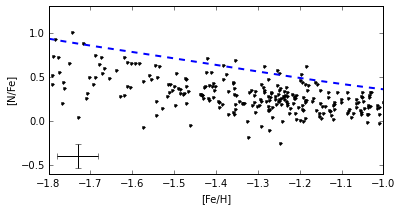

In [26]:
plt.figure(1)
plt.figure(figsize=(6,3))
plt.plot(d6['FE_H'],d6['nfe'],'.k')
plt.errorbar([-1.73],[-0.4],xerr=np.mean(d6['FE_H_ERR']),yerr=np.mean(d6['nfe_err']),color='black')
xax=(np.arange(81)*0.01)-1.8
div=np.polyval([0.2021005,0.9416563,1.288008,0.1487366,-0.371352,-0.08952794,0.2414398],xax)
#plt.plot(xax,div+4*0.0838233,'b',linestyle='--',linewidth=2)
plt.plot(xax,div,'b',linestyle='--',linewidth=2)
plt.xlabel('[Fe/H]')
plt.ylabel('[N/Fe]')
plt.xlim(-1.8,-1.)
plt.ylim(-0.6,1.3)
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_n_1.eps')
#plt.savefig(path1+'paper/figures/tag_n_1.eps')
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Leiden/chemtag5.eps')
#plt.savefig('/Users/Sarah/lapdesk/Ongoing/AAO-colloquium/tag_n_1.eps')

Which stars pass the cut?

In [5]:
ndiff=d6['nfe']-np.polyval([0.2021005,0.9416563,1.288008,0.1487366,-0.371352,-0.08952794,0.2414398],d6['FE_H'])
f6=np.where(ndiff>0)
d7=d6[f6]
#also grab the complement of f6 (that is, d6 without d7)
m6=np.ones(len(d6),np.bool)
m6[f6]=0
d7inv=d6[m6]

#now add a selection for cfe<+0.15 and call it d8 
f7=np.where(d7['cfe']<0.15)
d8=d7[f7]
m7=np.ones(len(d7),np.bool)
m7[f7]=0
d8inv=d7[m7]

#now add a selection for the N-Al plane and call it d9
f8=np.where((d8['nfe']<0.9) & (d8['nfe']>0.55))
d9=d8[f8]
m8=np.ones(len(d8),np.bool)
m8[f8]=0
d9inv=d8[m8]

In [104]:
print(len(d1),len(d2),len(d3),len(d4),len(d5),len(d6),len(d7),len(d8),len(d9),len(d9)/len(d6))

156593 135988 132928 132897 87252 253 11 9 5 0.019762845849802372


In [64]:
print(len(d3)-len(d2))

-3060


In [21]:
#grab just ID numbers, JHK and Teff for Anibal and Szabolcs to check photometric Teff with
dwri=d6['ASPCAP_ID','APOGEE_ID','J','H','K','teff']
dwri.write('/Users/sarah/active/programs/apogee-migrants/data/teffcheck.txt',format='ascii.tab')

/Users/sarah/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


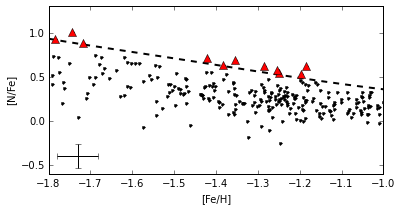

In [6]:
plt.figure(1)
plt.figure(figsize=(6,3))
plt.plot(d6['FE_H'],d6['nfe'],'.k')
plt.errorbar([-1.73],[-0.4],xerr=np.mean(d6['FE_H_ERR']),yerr=np.mean(d6['nfe_err']),color='black')
xax=(np.arange(81)*0.01)-1.8
div=np.polyval([0.2021005,0.9416563,1.288008,0.1487366,-0.371352,-0.08952794,0.2414398],xax)
plt.plot(xax,div,'k',linestyle='--',linewidth=2)
plt.plot(d7['FE_H'],d7['nfe'],'r^',markersize=8)
plt.xlabel('[Fe/H]')
plt.ylabel('[N/Fe]')
plt.xlim(-1.8,-1.)
plt.ylim(-0.6,1.3)
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_n_1.eps')
#plt.savefig(path1+'paper/figures/ff6.eps')
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Leiden/chemtag5.eps')
#plt.savefig('/Users/Sarah/lapdesk/Ongoing/SIfA-16/tag_n_2.eps')

Read in GC information for comparison in the N-Al plane

In [6]:
#m107 is out because its Al abundances are all kind of high
#cm107=Table.read(path1+'data/m107-nov15.fits')
#grab information for M2 and M5 starting from d2, using membership lists from Meszaros/Martell 2015
#m5 is out (for the figures) because it has too many stars!
#m5list=Table.read(path1+'data/m5-members-list.fits')
#m5listpre=[]
#for num in m5list:
#    m5listpre.append('2M'+num['_2MASS'])
#m5listcol=Column(m5listpre,name='APOGEE_ID')
#m5list.add_column(m5listcol)
#cm5=join(d2,m5list,keys='APOGEE_ID')
m2list=Table.read(path1+'data/m2-members-list.fits')
m2listpre=[]
for num in m2list:
    m2listpre.append('2M'+num['_2MASS'])
m2listcol=Column(m2listpre,name='APOGEE_ID')
m2list.add_column(m2listcol)
cm2=join(d2,m2list,keys='APOGEE_ID')
teffvec=[]
for i in range(len(cm2)):
    teffvec.append(((cm2['FPARAM'])[i])[0])
teffvec=Column(teffvec,name='teff')
cfe=Column(cm2['C_H']-cm2['FE_H'],name='cfe')
cfe_err=Column(np.sqrt((cm2['C_H_ERR']**2)+(cm2['FE_H_ERR']**2)),name='cfe_err')
nfe=Column(cm2['N_H']-cm2['FE_H'],name='nfe')
nfe_err=Column(np.sqrt((cm2['N_H_ERR']**2)+(cm2['FE_H_ERR']**2)),name='nfe_err')
alfe=Column(cm2['AL_H']-cm2['FE_H'],name='alfe')
alfe_err=Column(np.sqrt((cm2['AL_H_ERR']**2)+(cm2['FE_H_ERR']**2)),name='alfe_err')
mgfe=Column(cm2['MG_H']-cm2['FE_H'],name='mgfe')
mgfe_err=Column(np.sqrt((cm2['MG_H_ERR']**2)+(cm2['FE_H_ERR']**2)),name='mgfe_err')
cm2.add_column(teffvec)
cm2.add_column(cfe)
cm2.add_column(cfe_err)
cm2.add_column(nfe)
cm2.add_column(nfe_err)
cm2.add_column(alfe)
cm2.add_column(alfe_err)
cm2.add_column(mgfe)
cm2.add_column(mgfe_err)
cm3=Table.read(path1+'data/m3-nov15.fits')
teffvec=[]
for i in range(len(cm3)):
    teffvec.append(((cm3['FPARAM'])[i])[0])
teffvec=Column(teffvec,name='teff')
cfe=Column(cm3['C_H']-cm3['FE_H'],name='cfe')
cfe_err=Column(np.sqrt((cm3['C_H_ERR']**2)+(cm3['FE_H_ERR']**2)),name='cfe_err')
nfe=Column(cm3['N_H']-cm3['FE_H'],name='nfe')
nfe_err=Column(np.sqrt((cm3['N_H_ERR']**2)+(cm3['FE_H_ERR']**2)),name='nfe_err')
alfe=Column(cm3['AL_H']-cm3['FE_H'],name='alfe')
alfe_err=Column(np.sqrt((cm3['AL_H_ERR']**2)+(cm3['FE_H_ERR']**2)),name='alfe_err')
mgfe=Column(cm3['MG_H']-cm3['FE_H'],name='mgfe')
mgfe_err=Column(np.sqrt((cm3['MG_H_ERR']**2)+(cm3['FE_H_ERR']**2)),name='mgfe_err')
cm3.add_column(teffvec)
cm3.add_column(cfe)
cm3.add_column(cfe_err)
cm3.add_column(nfe)
cm3.add_column(nfe_err)
cm3.add_column(alfe)
cm3.add_column(alfe_err)
cm3.add_column(mgfe)
cm3.add_column(mgfe_err)
cm13=Table.read(path1+'data/m13-nov15.fits')
teffvec=[]
for i in range(len(cm13)):
    teffvec.append(((cm13['FPARAM'])[i])[0])
teffvec=Column(teffvec,name='teff')
cfe=Column(cm13['C_H']-cm13['FE_H'],name='cfe')
cfe_err=Column(np.sqrt((cm13['C_H_ERR']**2)+(cm13['FE_H_ERR']**2)),name='cfe_err')
nfe=Column(cm13['N_H']-cm13['FE_H'],name='nfe')
nfe_err=Column(np.sqrt((cm13['N_H_ERR']**2)+(cm13['FE_H_ERR']**2)),name='nfe_err')
alfe=Column(cm13['AL_H']-cm13['FE_H'],name='alfe')
alfe_err=Column(np.sqrt((cm13['AL_H_ERR']**2)+(cm13['FE_H_ERR']**2)),name='alfe_err')
mgfe=Column(cm13['MG_H']-cm13['FE_H'],name='mgfe')
mgfe_err=Column(np.sqrt((cm13['MG_H_ERR']**2)+(cm13['FE_H_ERR']**2)),name='mgfe_err')
cm13.add_column(teffvec)
cm13.add_column(cfe)
cm13.add_column(cfe_err)
cm13.add_column(nfe)
cm13.add_column(nfe_err)
cm13.add_column(alfe)
cm13.add_column(alfe_err)
cm13.add_column(mgfe)
cm13.add_column(mgfe_err)
#cm15=Table.read('/Users/sarah/active/programs/apogee-migrants/data/m15-nov15.fits')
gc_feh=np.concatenate([cm3['FE_H'],cm13['FE_H'],cm2['FE_H']])
gc_cfe=np.concatenate([cm3['cfe'],cm13['cfe'],cm2['cfe']])
gc_cfe_err=np.concatenate([cm3['cfe_err'],cm13['cfe_err'],cm2['cfe_err']])
gc_nfe=np.concatenate([cm3['nfe'],cm13['nfe'],cm2['nfe']])
gc_nfe_err=np.concatenate([cm3['nfe_err'],cm13['nfe_err'],cm2['nfe_err']])
gc_alfe=np.concatenate([cm3['alfe'],cm13['alfe'],cm2['alfe']])
gc_alfe_err=np.concatenate([cm3['alfe_err'],cm13['alfe_err'],cm2['alfe_err']])
gc_mgfe=np.concatenate([cm3['mgfe'],cm13['mgfe'],cm2['mgfe']])
gc_mgfe_err=np.concatenate([cm3['mgfe_err'],cm13['mgfe_err'],cm2['mgfe_err']])
gc_teff=np.concatenate([cm3['TEFF'],cm13['TEFF'],cm2['TEFF']])

Identify "bona fide" C-rich stars using the definition from Schiavon 2016

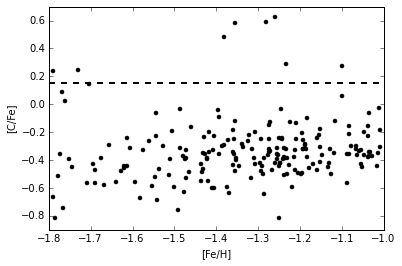

In [14]:
plt.plot(d6['FE_H'],d6['cfe'],'ko',markersize=4)
plt.plot([-1.8,-1.],[0.15,0.15],'k',linestyle='--',linewidth=2)
plt.xlabel('[Fe/H]')
plt.ylabel('[C/Fe]')
plt.xlim([-1.8,-1.])
plt.ylim([-0.9,0.7])
#plt.savefig('/Users/sarah/active/programs/apogee-migrants/work/fehcfe.ps')

Figure out if any of the 9 N-rich stars are also C-rich (same criterion as in Schiavon 2016)

(-0.3, 1.1)

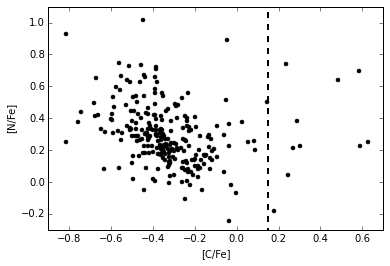

In [11]:
plt.plot(d6['cfe'],d6['nfe'],'ko',markersize=4)
#plt.plot(d8['cfe'],d8['nfe'],'ro',markersize=13)
#plt.plot(d8inv['cfe'],d8inv['nfe'],'co',markersize=13)
plt.plot([0.15,0.15],[-0.4,1.2],'k',linestyle='--',linewidth=2)
plt.xlabel('[C/Fe]')
plt.ylabel('[N/Fe]')
plt.xlim([-0.9,0.7])
plt.ylim([-0.3,1.1])
#plt.savefig('/Users/Sarah/lapdesk/Ongoing/AAO-colloquium/tag_c_n_1.eps')
#plt.savefig('/Users/sarah/active/programs/apogee-migrants/work/cfenfe.ps')

In [6]:
np.where(d6['cfe']>0.3)

(array([ 55, 124, 155, 167, 205, 225]),)

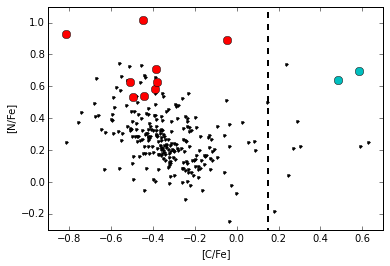

In [10]:
plt.plot(d6['cfe'],d6['nfe'],'k.')
plt.plot(d8['cfe'],d8['nfe'],'ro',markersize=8)
plt.plot(d8inv['cfe'],d8inv['nfe'],'co',markersize=8)
plt.plot([0.15,0.15],[-0.4,1.2],'k',linestyle='--',linewidth=2)
plt.xlabel('[C/Fe]')
plt.ylabel('[N/Fe]')
plt.xlim([-0.9,0.7])
plt.ylim([-0.3,1.1])
#plt.savefig('/Users/Sarah/lapdesk/Ongoing/SIfA-16/tag_c_n_2.eps')

(-0.8, 1.1)

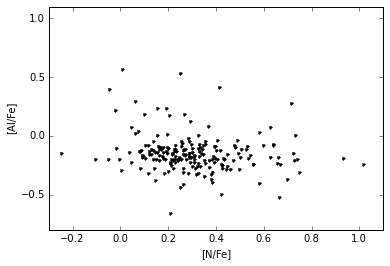

In [10]:
plt.plot(d6['nfe'],d6['alfe'],'k.')
#plt.plot(cm3['nfe'],cm3['alfe'],'ms')
#plt.plot(cm13['nfe'],cm13['alfe'],'bo')
#plt.plot(d8['nfe'],d8['alfe'],'ro')
#plt.plot(d8inv['nfe'],d8inv['alfe'],'go')
#plt.plot([-0.3,1.1],[np.mean(d7inv['alfe']),np.mean(d7inv['alfe'])])
plt.xlabel('[N/Fe]')
plt.ylabel('[Al/Fe]')
plt.xlim([-0.3,1.1])
plt.ylim([-0.8,1.1])
#plt.savefig('/Users/Sarah/lapdesk/Ongoing/AAO-colloquium/tag_n_al_1.eps')

(-0.8, 1.1)

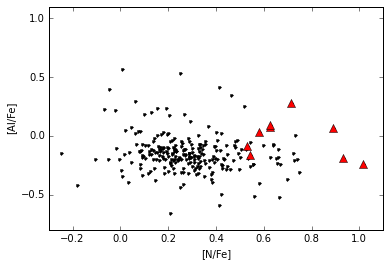

In [14]:
plt.plot(d6['nfe'],d6['alfe'],'k.')
#plt.plot(cm3['nfe'],cm3['alfe'],'ms')
#plt.plot(cm13['nfe'],cm13['alfe'],'bo')
plt.plot(d8['nfe'],d8['alfe'],'r^',markersize=8)
#plt.plot(d8inv['nfe'],d8inv['alfe'],'go')
#plt.plot([-0.3,1.1],[np.mean(d7inv['alfe']),np.mean(d7inv['alfe'])])
plt.xlabel('[N/Fe]')
plt.ylabel('[Al/Fe]')
plt.xlim([-0.3,1.1])
plt.ylim([-0.8,1.1])
#plt.savefig('/Users/Sarah/lapdesk/Ongoing/AAO-colloquium/tag_n_al_2.eps')

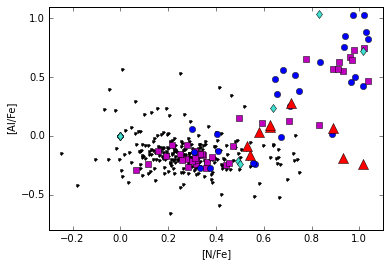

In [7]:
plt.plot(d6['nfe'],d6['alfe'],'k.')
plt.plot(cm3['nfe'],cm3['alfe'],'ms',markersize=6)
plt.plot(cm13['nfe'],cm13['alfe'],'bo',markersize=6)
plt.plot(cm2['nfe'],cm2['alfe'],'d',markersize=6,color='turquoise')
plt.plot(d8['nfe'],d8['alfe'],'r^',markersize=10)
#plt.plot(d8inv['nfe'],d8inv['alfe'],'go')
#plt.plot([-0.3,1.1],[np.mean(d7inv['alfe']),np.mean(d7inv['alfe'])])
plt.xlabel('[N/Fe]')
plt.ylabel('[Al/Fe]')
plt.xlim([-0.3,1.1])
plt.ylim([-0.8,1.1])
#plt.savefig('/Users/Sarah/lapdesk/Ongoing/SIfA-16/tag_n_al_3.eps')
#plt.savefig(path1+'paper/figures/ff7.eps')

(-0.8, 1.1)

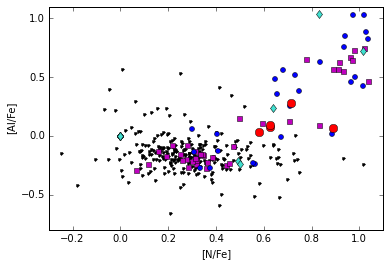

In [106]:
plt.plot(d6['nfe'],d6['alfe'],'k.')
plt.plot(cm3['nfe'],cm3['alfe'],'ms',markersize=5)
plt.plot(cm13['nfe'],cm13['alfe'],'bo',markersize=5)
plt.plot(cm2['nfe'],cm2['alfe'],'d',markersize=6,color='turquoise')
plt.plot(d9['nfe'],d9['alfe'],'ro',markersize=8)
#plt.plot(d8inv['nfe'],d8inv['alfe'],'go')
#plt.plot([-0.3,1.1],[np.mean(d7inv['alfe']),np.mean(d7inv['alfe'])])
plt.xlabel('[N/Fe]')
plt.ylabel('[Al/Fe]')
plt.xlim([-0.3,1.1])
plt.ylim([-0.8,1.1])
#plt.savefig('/Users/Sarah/lapdesk/Ongoing/SIfA-16/tag_n_al_4.eps')

In [18]:
d9

APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,H,H_ERR,K,K_ERR,RA,DEC,GLON,GLAT,APOGEE_TARGET1,APOGEE_TARGET2,TARGFLAGS,NVISITS,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,VERR_MED,SYNTHVHELIO_AVG,SYNTHVSCATTER,SYNTHVERR,SYNTHVERR_MED,RV_TEFF,RV_LOGG,RV_FEH,RV_CCFWHM,RV_AUTOFWHM,SYNTHSCATTER,STABLERV_CHI2 [2],STABLERV_RCHI2 [2],CHI2_THRESHOLD [2],STABLERV_CHI2_PROB [2],APSTAR_VERSION,ASPCAP_VERSION,RESULTS_VERSION,EXTRATARG,PARAM [7],FPARAM [7],"PARAM_COV [7,7]","FPARAM_COV [7,7]",ELEM [15],FELEM [15],ELEM_ERR [15],FELEM_ERR [15],TEFF,LOGG,PARAM_M_H,PARAM_ALPHA_M,TEFF_ERR,LOGG_ERR,PARAM_M_H_ERR,PARAM_ALPHA_M_ERR,ASPCAP_CHI2,ASPCAP_CLASS,ASPCAPFLAG,ASPCAPFLAGS,PARAMFLAG [7],AL_H,CA_H,C_H,FE_H,K_H,MG_H,MN_H,NA_H,NI_H,N_H,O_H,SI_H,S_H,TI_H,V_H,AL_H_ERR,CA_H_ERR,C_H_ERR,FE_H_ERR,K_H_ERR,MG_H_ERR,MN_H_ERR,NA_H_ERR,NI_H_ERR,N_H_ERR,O_H_ERR,SI_H_ERR,S_H_ERR,TI_H_ERR,V_H_ERR,AL_H_FLAG,CA_H_FLAG,C_H_FLAG,FE_H_FLAG,K_H_FLAG,MG_H_FLAG,MN_H_FLAG,NA_H_FLAG,NI_H_FLAG,N_H_FLAG,O_H_FLAG,SI_H_FLAG,S_H_FLAG,TI_H_FLAG,V_H_FLAG,ELEM_CHI2 [15],ELEMFLAG [15],REDUCTION_ID,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC,ALL_VISITS,VISITS,ALL_VISIT_PK [50],VISIT_PK [50],OBSTE,OBSLOGG,OBSFEH,OBSMAG,DISO [3],DISO_SIG,DISO_GAL [3],DISO_SIG_GAL,DMASS [3],DMASS_SIG,DMASS_GAL [3],DMASS_SIG_GAL,MH [3],MH_SIG,MASS [3],MASS_SIG,AGE [3],AGE_SIG,DISO_RAN [100],DMASS_RAN [100],AGE_RAN [100],dist,logg,teff,z_height,cfe,cfe_err,nfe,nfe_err,alfe,alfe_err,mgfe,mgfe_err
str1440,str1088,str1408,str1088,str576,str256,int16,str512,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int32,int32,str3712,int32,int16,float32,int32,str4128,int32,str1888,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str160,str192,str128,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str64,int32,str4896,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,int32,str576,str384,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str544,float32,float32,int16,int16,float32,float32,str640,str23584,str21280,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32
apogee.apo25m.s.stars.4485.2M12555505+4043433,4485.2M12555505+4043433,apogee.apo25m.s.v603.4485.2M12555505+4043433,apStar-r5-2M12555505+4043433.fits,2M12555505+4043433,apo25m,4485,120+75,11.906,0.021,11.2,0.02,11.079,0.02,193.979409,40.728706,119.328897035,76.3683184052,-2147481600,0,APOGEE_SHORT,3,0,154.854,2048,PERSIST_LOW,2048,PERSIST_LOW,-62.9126,2.46953,0.0234638,0.0411659,-62.826,2.38429,0.0194708,0.0341735,4000.0,2.0,-1.5,23.1483,20.624,0.184854,7585.57 .. 10385.8,61.5856 .. 72.0617,13.8156 .. 13.8156,0.0 .. 0.0,stars,l25_6d,v603,0,4159.1 .. 0.426711,4069.6 .. 0.43874,8366.16 .. 0.00137283,5.366 .. 2.1466e-05,-0.45925 .. -1.43436,-0.45925 .. -1.3809,0.0839332 .. 0.0708254,0.00935495 .. 0.0148617,4159.1,0.566073,-1.59476,0.426711,91.4667,0.106893,0.0476264,0.0370518,5.58496,GK,0,,0 .. 512,-1.1427,-1.27711,-1.80765,-1.421

In [ ]:
plt.plot(d6['dist'],d6['nfe'],'k.')
plt.plot(d8['dist'],d8['nfe'],'ro')
plt.plot(d8inv['dist'],d8inv['nfe'],'go')

In [ ]:
np.mean(d7inv['alfe'])

In [ ]:
d7

Figure out if any of the previously noted GC migrants are among the APOGEE stars with reasonable parameters (subset d5 here)
Answer: No.

In [26]:
m11=Table.read('/Users/sarah/active/programs/apogee-migrants/data/segue_migrants.fits')

In [27]:
lb=[]
for item in m11['SDSS']:
    lb.append(item[1:].replace('.',''))

In [28]:
lb=Column(data=lb,name='abbrevID')

In [29]:
m11.add_column(lb)

In [ ]:
m11[0:4]

In [ ]:
d5[4150:4152]

In [30]:
lc=[]
for item in d5['APOGEE_ID']:
    lc.append(item[2:])

In [31]:
lc=Column(data=lc,name='abbrevID')

In [32]:
d5.add_column(lc)

In [33]:
reobs=join(m11,d5,keys='abbrevID')

In [34]:
reobs

_RAJ2000,_DEJ2000,SDSS,Plate,MJD,Fiber,g0,__g-r_0,__Fe_H_,Teff,logg_1,S,S_CN_,S_CH_,CN,rMAG,Dist,rGC,Sloan,RAJ2000,DEJ2000,abbrevID,APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,H,H_ERR,K,K_ERR,RA,DEC,GLON,GLAT,APOGEE_TARGET1,APOGEE_TARGET2,TARGFLAGS,NVISITS,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,VERR_MED,SYNTHVHELIO_AVG,SYNTHVSCATTER,SYNTHVERR,SYNTHVERR_MED,RV_TEFF,RV_LOGG,RV_FEH,RV_CCFWHM,RV_AUTOFWHM,SYNTHSCATTER,STABLERV_CHI2 [2],STABLERV_RCHI2 [2],CHI2_THRESHOLD [2],STABLERV_CHI2_PROB [2],APSTAR_VERSION,ASPCAP_VERSION,RESULTS_VERSION,EXTRATARG,PARAM [7],FPARAM [7],"PARAM_COV [7,7]","FPARAM_COV [7,7]",ELEM [15],FELEM [15],ELEM_ERR [15],FELEM_ERR [15],TEFF,LOGG,PARAM_M_H,PARAM_ALPHA_M,TEFF_ERR,LOGG_ERR,PARAM_M_H_ERR,PARAM_ALPHA_M_ERR,ASPCAP_CHI2,ASPCAP_CLASS,ASPCAPFLAG,ASPCAPFLAGS,PARAMFLAG [7],AL_H,CA_H,C_H,FE_H,K_H,MG_H,MN_H,NA_H,NI_H,N_H,O_H,SI_H,S_H,TI_H,V_H,AL_H_ERR,CA_H_ERR,C_H_ERR,FE_H_ERR,K_H_ERR,MG_H_ERR,MN_H_ERR,NA_H_ERR,NI_H_ERR,N_H_ERR,O_H_ERR,SI_H_ERR,S_H_ERR,TI_H_ERR,V_H_ERR,AL_H_FLAG,CA_H_FLAG,C_H_FLAG,FE_H_FLAG,K_H_FLAG,MG_H_FLAG,MN_H_FLAG,NA_H_FLAG,NI_H_FLAG,N_H_FLAG,O_H_FLAG,SI_H_FLAG,S_H_FLAG,TI_H_FLAG,V_H_FLAG,ELEM_CHI2 [15],ELEMFLAG [15],REDUCTION_ID,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC,ALL_VISITS,VISITS,ALL_VISIT_PK [50],VISIT_PK [50],OBSTE,OBSLOGG,OBSFEH,OBSMAG,DISO [3],DISO_SIG,DISO_GAL [3],DISO_SIG_GAL,DMASS [3],DMASS_SIG,DMASS_GAL [3],DMASS_SIG_GAL,MH [3],MH_SIG,MASS [3],MASS_SIG,AGE [3],AGE_SIG,DISO_RAN [100],DMASS_RAN [100],AGE_RAN [100],dist,logg_2,teff,z_height
deg,deg,,,,,mag,mag,[Sun],K,[cm/s2],,mag,mag,,mag,kpc,kpc,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
float64,float64,str608,int16,int32,int16,float32,float32,float32,int16,float32,str32,float32,float32,str32,float32,float32,float32,str160,float64,float64,str512,str1440,str1088,str1408,str1088,str576,str256,int16,str512,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int32,int32,str3712,int32,int16,float32,int32,str4128,int32,str1888,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str160,str192,str128,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str64,int32,str4896,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,int32,str576,str384,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str544,float32,float32,int16,int16,float32,float32,str640,str23584,str21280,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64


Useful figures

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,6))
plt.plot(d1['FPARAM'][:,0],d1['FPARAM'][:,1],'k.')
plt.xlim(7200.,3600.)
plt.ylim(4.,-0.5)
plt.plot(d3['FPARAM'][:,0],d3['FPARAM'][:,1],'.',color='dodgerblue')
plt.plot(d5['teff'],d5['logg'],'.',color='darkorchid')
plt.plot(d6['teff'],d6['logg'],'.',color='lawngreen')
plt.xlabel('T$_{eff}$')
plt.ylabel('log(g)')
#plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/selection1.eps')
#plt.savefig(path1+'paper/figures/selection1.eps')
plt.savefig('/Users/Sarah/Desktop/Ongoing/Leiden/selection1.eps')

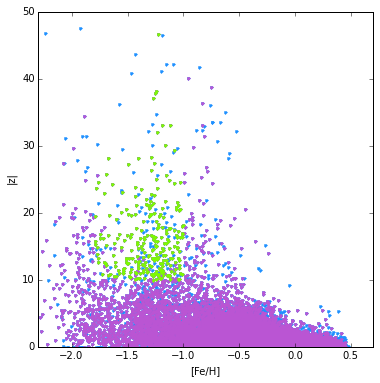

In [92]:
plt.figure(1)
plt.figure(figsize=(6,6))
#plt.plot(d1['FE_H'],(d1['DISO'][:,1])*np.sin((np.pi*np.absolute(d1['GLAT'])/180)),'k.')
plt.xlim(-2.3,0.7)
plt.ylim(0,50)
plt.plot(d3['FE_H'],(d3['DISO'][:,1])*np.sin((np.pi*np.absolute(d3['GLAT'])/180)),'.',color='dodgerblue')
plt.plot(d5['FE_H'],d5['z_height'],'.',color='mediumorchid')
plt.plot(d6['FE_H'],d6['z_height'],'.',color='lawngreen')
plt.xlabel('[Fe/H]')
plt.ylabel('|z|')
#plt.show()
#plt.savefig('/Users/Sarah/lapdesk/Ongoing/SIfA-16/selection2.tiff')
#plt.savefig(path1+'paper/figures/selection2.eps')
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Leiden/selection2.eps')

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,6))
#plt.plot((d1['DISO'][:,1])*np.sin((np.pi*np.absolute(d1['GLAT'])/180)),d1['N_H']-d1['FE_H'],'k.')
plt.xlim(0.,50.)
plt.ylim(-1.2,1.2)
plt.plot((d3['DISO'][:,1])*np.sin((np.pi*np.absolute(d3['GLAT'])/180)),d3['N_H']-d3['FE_H'],'.',color='dodgerblue')
plt.plot(d5['z_height'],d5['N_H']-d5['FE_H'],'.',color='mediumorchid')
plt.plot(d6['z_height'],d6['N_H']-d6['FE_H'],'.',color='lawngreen')
plt.xlabel('D')
plt.ylabel('[N/Fe]')
#plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/selection3.eps')
plt.savefig(path1+'paper/figures/selection3.eps')

In [65]:
print(len(d1),len(d2),len(d1)-len(d2),len(d3),len(d2)-len(d3),len(d4),len(d3)-len(d4),len(d5),len(d6))

156593 135988 20605 132928 3060 132897 31 87252 253


Choose which abundances to use for tagging

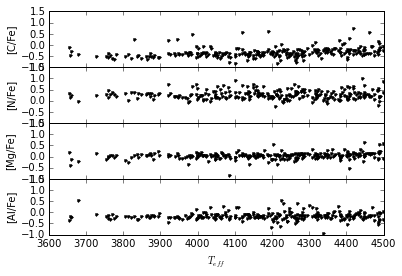

In [13]:
f,(ax1,ax2,ax3,ax4)=plt.subplots(4,sharex=True,sharey=True)
ax1.plot(d6['teff'],d6['cfe'],'.k')
ax1.set_ylabel('[C/Fe]')
ax2.plot(d6['teff'],d6['nfe'],'.k')
#ax1.plot(cm3['teff'],cm3['nfe'],'o',color='dodgerblue')
#ax1.plot(cm13['teff'],cm13['nfe'],'s',color='darkorchid')
ax2.set_ylabel('[N/Fe]')
ax3.plot(d6['teff'],d6['mgfe'],'.k')
#ax2.plot(cm3['teff'],cm3['mgfe'],'o',color='dodgerblue')
#ax2.plot(cm13['teff'],cm13['mgfe'],'s',color='darkorchid')
ax3.set_ylabel('[Mg/Fe]')
ax4.plot(d6['teff'],d6['alfe'],'.k')
#ax3.plot(cm3['teff'],cm3['alfe'],'o',color='dodgerblue')
#ax3.plot(cm13['teff'],cm13['alfe'],'s',color='darkorchid')
ax4.set_ylabel('[Al/Fe]')
plt.xlabel('$T_{eff}$')
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]],visible=False)
plt.ylim(-1,1.5)
plt.show()
#plt.savefig(path1+'paper/figures/ff5.eps')
#plt.savefig('/Users/sarah/Desktop/Ongoing/Leiden/chemtag1a.eps')

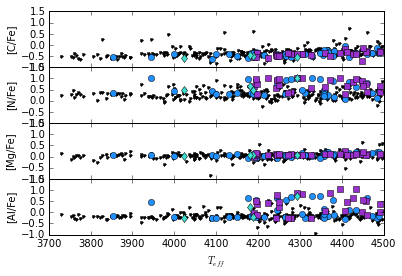

In [17]:
f,(ax1,ax2,ax3,ax4)=plt.subplots(4,sharex=True,sharey=True)
ax1.plot(d6['teff'],d6['cfe'],'.k')
ax1.plot(cm3['teff'],cm3['cfe'],'o',color='dodgerblue')
ax1.plot(cm13['teff'],cm13['cfe'],'s',color='darkorchid')
ax1.plot(cm2['teff'],cm2['cfe'],'d',color='turquoise')
ax1.set_xlim(3700,4500)
ax1.set_ylabel('[C/Fe]')
ax2.plot(d6['teff'],d6['nfe'],'.k')
ax2.plot(cm3['teff'],cm3['nfe'],'o',color='dodgerblue')
ax2.plot(cm13['teff'],cm13['nfe'],'s',color='darkorchid')
ax2.plot(cm2['teff'],cm2['nfe'],'d',color='turquoise')
#ax2.ylim(-0.5,1.4)
ax2.set_ylabel('[N/Fe]')
ax3.plot(d6['teff'],d6['mgfe'],'.k')
ax3.plot(cm3['teff'],cm3['mgfe'],'o',color='dodgerblue')
ax3.plot(cm13['teff'],cm13['mgfe'],'s',color='darkorchid')
ax3.plot(cm2['teff'],cm2['mgfe'],'d',color='turquoise')
#ax3.ylim(-1,0.9)
ax3.set_ylabel('[Mg/Fe]')
ax4.plot(d6['teff'],d6['alfe'],'.k')
ax4.plot(cm3['teff'],cm3['alfe'],'o',color='dodgerblue')
ax4.plot(cm13['teff'],cm13['alfe'],'s',color='darkorchid')
ax4.plot(cm2['teff'],cm2['alfe'],'d',color='turquoise')
#ax4.ylim(-1.1,1.5)
ax4.set_ylabel('[Al/Fe]')
plt.xlabel('$T_{eff}$')
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]],visible=False)
plt.ylim(-1,1.5)
plt.show()
#plt.savefig(path1+'paper/figures/ff5.eps')
#plt.savefig('/Users/sarah/Desktop/Ongoing/Leiden/chemtag1b.eps')

In [ ]:
plt.plot(d6['nfe'],d6['alfe'],'.k')
#plt.plot(cm3['nfe'],cm3['alfe'],'o',color='dodgerblue')
#plt.plot(cm13['nfe'],cm13['alfe'],'s',color='darkorchid')
plt.xlabel('[N/Fe]')
plt.ylabel('[Al/Fe]')
plt.xlim(-0.3,1.1)
plt.ylim(-0.8,1.2)
#plt.show()
#plt.savefig(path1+'paper/figures/ff6.eps')
plt.savefig('/Users/sarah/Desktop/Ongoing/Leiden/chemtag2a.eps')

In [ ]:
plt.plot(d6['nfe'],d6['alfe'],'.k')
plt.plot(cm3['nfe'],cm3['alfe'],'o',color='dodgerblue')
plt.plot(cm13['nfe'],cm13['alfe'],'s',color='darkorchid')
plt.xlabel('[N/Fe]')
plt.ylabel('[Al/Fe]')
plt.xlim(-0.3,1.1)
plt.ylim(-0.8,1.2)
#plt.show()
#plt.savefig(path1+'paper/figures/ff6.eps')
plt.savefig('/Users/sarah/Desktop/Ongoing/Leiden/chemtag2a.eps')

In [ ]:
plt.figure(1)
plt.figure(figsize=(4,3))
plt.plot(d7inv['dist'],d7inv['nfe'],'.k')
plt.plot(d7['dist'],d7['nfe'],'sb')
plt.xlabel('D')
plt.ylabel('[N/Fe]')

Calculate Galactic coordinates

In [111]:
rdd6inv=coord.ICRS(ra=d6inv['RA']*u.degree,dec=d6inv['DEC']*u.degree,distance=d6inv['dist']*u.kpc)
xyz6inv=rdd6inv.transform_to(coord.Galactocentric) 
rdd7inv=coord.ICRS(ra=d7inv['RA']*u.degree,dec=d7inv['DEC']*u.degree,distance=d7inv['dist']*u.kpc)
xyz7inv=rdd7inv.transform_to(coord.Galactocentric)
#rddtag=coord.ICRS(ra=(d7['RA'])*u.degree,dec=(d7['DEC'])*u.degree,distance=(d7['dist'])*u.kpc)
#xyztag=rddtag.transform_to(coord.Galactocentric) 
rdd8inv=coord.ICRS(ra=d8inv['RA']*u.degree,dec=d8inv['DEC']*u.degree,distance=d8inv['dist']*u.kpc)
xyz8inv=rdd8inv.transform_to(coord.Galactocentric)
rdd9inv=coord.ICRS(ra=d9inv['RA']*u.degree,dec=d9inv['DEC']*u.degree,distance=d9inv['dist']*u.kpc)
xyz9inv=rdd9inv.transform_to(coord.Galactocentric)
rdd9=coord.ICRS(ra=(d9['RA'])*u.degree,dec=(d9['DEC'])*u.degree,distance=(d9['dist'])*u.kpc)
xyz9=rdd9.transform_to(coord.Galactocentric) 
#rddtaginv=coord.ICRS(ra=ctaginv['RA']*u.degree,dec=ctaginv['DEC']*u.degree,distance=ctaginv['dist']*u.kpc)
#xyztaginv=rddtaginv.transform_to(coord.Galactocentric)

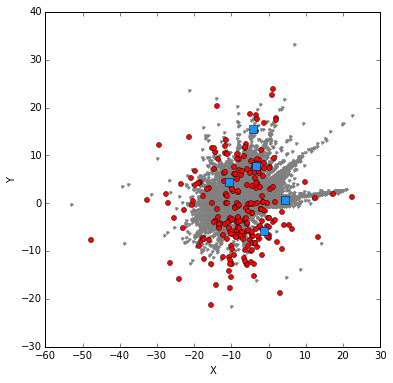

In [113]:
#ax1 = plt.subplot(121)
plt.figure(1)
plt.figure(figsize=(6,6))
plt.plot(xyz6inv.x,xyz6inv.y,'.',color='grey')
#plt.plot(xyz7inv.x,xyz7inv.y,'o',color='darkorchid',ms=8)
plt.plot(xyz7inv.x,xyz7inv.y,'o',color='red',ms=5)
plt.plot(xyz9.x,xyz9.y,'s',color='dodgerblue',ms=8)
plt.xlabel('X')
plt.ylabel('Y')
#plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_X_Y.eps')
#plt.savefig(path1+'paper/figures/ff2.tiff')
#plt.savefig('/Users/Sarah/lapdesk/Ongoing/SIfA-16/tag_X_Y.tiff')

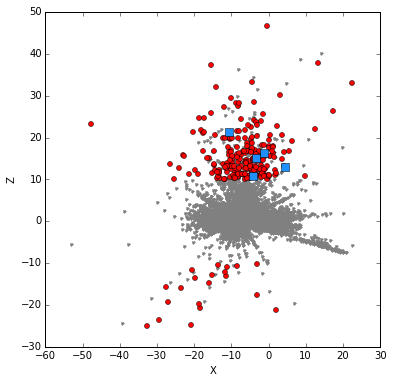

In [115]:
plt.figure(1)
plt.figure(figsize=(6,6))
plt.plot(xyz6inv.x,xyz6inv.z,'.',color='grey')
#plt.plot(xyz7inv.x,xyz7inv.z,'o',color='darkorchid',ms=8)
plt.plot(xyz7inv.x,xyz7inv.z,'o',color='red',ms=5)
plt.plot(xyz9.x,xyz9.z,'s',color='dodgerblue',ms=8)
plt.xlabel('X')
plt.ylabel('Z')
#plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_X_Z.eps')
#plt.savefig(path1+'paper/figures/ff3.tiff')
#plt.savefig('/Users/Sarah/lapdesk/Ongoing/SIfA-16/tag_X_Z.tiff')

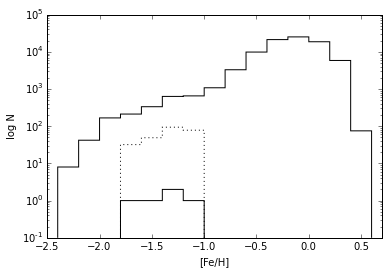

In [117]:
plt.hist(d5['FE_H'],bins=(np.arange(16)*0.2)-2.4,histtype='step',log=True,color='black', linestyle='solid') 
plt.hist(d6['FE_H'],bins=(np.arange(5)*0.2)-1.8,histtype='step',log=True,color='black', linestyle='dotted')
plt.hist((d9['FE_H']),bins=(np.arange(5)*0.2)-1.8,histtype='step',log=True,color='black', linestyle='solid')
plt.xlabel('[Fe/H]')
plt.ylabel('log N')
plt.xlim(-2.5,0.7)
#plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_met_hist.eps')
#plt.savefig(path1+'paper/figures/ff4.eps')
#plt.savefig('/Users/Sarah/lapdesk/Ongoing/SIfA-16/tag_met_hist.eps')

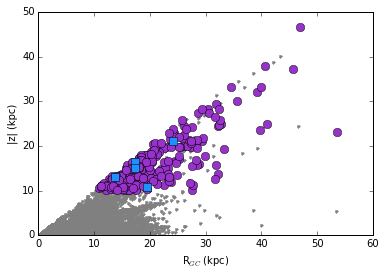

In [119]:
rgcd6inv=np.sqrt((xyz6inv.x)**2+(xyz6inv.y)**2+(xyz6inv.z)**2)
rgcd7inv=np.sqrt((xyz7inv.x)**2+(xyz7inv.y)**2+(xyz7inv.z)**2)
rgcd8inv=np.sqrt((xyz8inv.x)**2+(xyz8inv.y)**2+(xyz8inv.z)**2)
rgcd9inv=np.sqrt((xyz9inv.x)**2+(xyz9inv.y)**2+(xyz9inv.z)**2)
rgcd9=np.sqrt((xyz9.x)**2+(xyz9.y)**2+(xyz9.z)**2)
#rgcctaginv=np.sqrt((xyztaginv.x)**2+(xyztaginv.y)**2+(xyztaginv.z)**2)
#rgcctag=np.sqrt((xyztag.x)**2+(xyztag.y)**2+(xyztag.z)**2)
plt.plot(rgcd6inv,d6inv['z_height'],'.',color='grey')
#plt.plot(rgcd6,d6['z_height'],'o',color='darkorchid')
plt.plot(rgcd7inv,d7inv['z_height'],'o',color='darkorchid',ms=8)
plt.plot(rgcd9,(d9['z_height']),'s',color='dodgerblue',ms=8)
#plt.plot(d6inv['FE_H'],d6inv['z_height'],'.',color='grey')
#plt.plot(ctaginv['FE_H'],ctaginv['z_height'],'o',color='darkorchid')
#plt.plot((d6['FE_H'])[ctag],(d6['z_height'])[ctag],'s',color='dodgerblue')
plt.xlabel('R$_{GC}$ (kpc)')
plt.ylabel('|z| (kpc)')
#plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_rgc_z.eps')
#plt.savefig('/Users/Sarah/lapdesk/Ongoing/SIfA-16/tag_rgc_z.tiff')

In [28]:
rgcd9

<Quantity [ 24.20785162, 38.37851946, 17.37734627, 13.77288986,
            18.47886347] kpc>

/Users/sarah/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


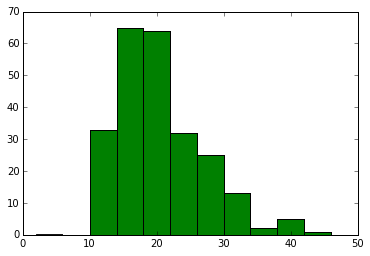

In [120]:
#dax=(np.arange(17)*3.)+1.
dax=(np.arange(12)*4.)+2.
#f1,f2,f3=plt.hist((d6['dist'])[ctag],bins=dax)
f1,f2,f3=plt.hist(rgcd9,bins=dax)
#f4,f5,f6=plt.hist(ctaginv['dist'],bins=dax)
f4,f5,f6=plt.hist(rgcd7inv,bins=dax)
ifrac=f1/f4
ifrac[np.where(np.isnan(ifrac))]=0.

In [121]:
np.insert(ifrac,0,0.)

array([ 0.        ,  0.        ,  0.        ,  0.03030303,  0.03076923,
        0.015625  ,  0.03125   ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

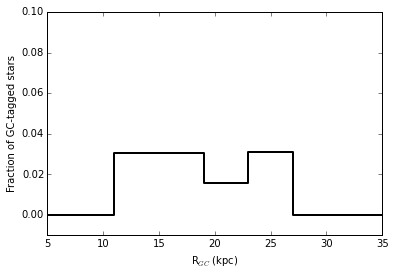

In [126]:
plt.plot(dax+1,np.insert(ifrac,0,0.),linestyle='solid',drawstyle='steps',color='black',linewidth=2)
plt.xlabel('R$_{GC}$ (kpc)')
plt.ylabel('Fraction of GC-tagged stars')
plt.xlim(5,35)
plt.ylim(-0.01,0.1)
#plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_rgc_frac.eps')
#plt.savefig('/Users/Sarah/lapdesk/Ongoing/SIfA-16/tag_rgc_frac.eps')

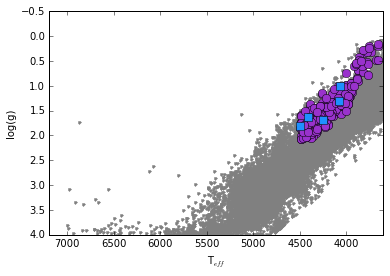

In [124]:
plt.plot(d6inv['teff'],d6inv['logg'],'.',color='grey')
plt.plot(d7inv['teff'],d7inv['logg'],'o',color='darkorchid',ms=8)
plt.plot((d9['teff']),(d9['logg']),'s',color='dodgerblue',ms=8)
plt.xlim(7200,3600)
plt.ylim(4,-0.5)
plt.xlabel('T$_{eff}$')
plt.ylabel('log(g)')
#plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_logg_teff.eps')
#plt.savefig('/Users/Sarah/lapdesk/Ongoing/SIfA-16/tag_logg_teff.tiff')

Old figures/other ways to do tagging & selection

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,6))
plt.plot(d6['FE_H'],d6['nfe'],'.',color='darkgrey')
plt.errorbar([-1.73],[-0.4],xerr=np.mean(d6['FE_H_ERR']),yerr=np.mean(d6['nfe_err']),color='black')
plt.plot(cm3['FE_H'],cm3['nfe'],'o',color='dodgerblue',fillstyle='full')
plt.errorbar([-1.6],[-0.4],xerr=np.mean(cm3['FE_H_ERR']),yerr=np.mean(cm3['nfe_err']),color='dodgerblue')
plt.plot(cm13['FE_H'],cm13['nfe'],'s',color='darkorchid',fillstyle='full')
plt.errorbar([-1.47],[-0.4],xerr=np.mean(cm13['FE_H_ERR']),yerr=np.mean(cm13['nfe_err']),color='darkorchid')
plt.xlabel('[Fe/H]')
plt.ylabel('[N/Fe]')
plt.ylim(-0.6,1.3)
ll=np.polyfit(d6['FE_H'],d6['nfe'],1)
#ll=np.polyfit(gc_feh[gc_nfe<0.5],gc_nfe[gc_nfe<0.5],1)
xax=np.arange(9)*0.1-1.8
plt.plot(xax,xax*ll[0]+ll[1],color='black')
plt.plot(xax,xax*ll[0]+ll[1]+0.43,color='black')
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_n_2.eps')
#plt.savefig(path1+'paper/figures/tag_n_2.eps')

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,3))
plt.plot(d6['teff'],d6['nfe'],'.k')
#plt.errorbar([3750],[-0.4],xerr=np.mean(d6['TEFF_ERR']),yerr=np.mean(d6['nfe_err']),color='black')
#plt.plot(cm3['TEFF'],cm3['nfe'],'o',color='dodgerblue',fillstyle='full')
#plt.plot(cm13['TEFF'],cm13['nfe'],'s',color='darkorchid',fillstyle='full')
plt.xlabel('$T_{eff}$')
plt.ylabel('[N/Fe]')
plt.ylim(-0.6,1.3)
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_n_1.eps')
#plt.savefig(path1+'paper/figures/tag_n_1.eps')
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Leiden/chemtag3a.eps')

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,3))
plt.plot(d6['teff'],d6['nfe'],'.k')
#plt.errorbar([3750],[-0.4],xerr=np.mean(d6['TEFF_ERR']),yerr=np.mean(d6['nfe_err']),color='black')
plt.plot(cm3['teff'],cm3['nfe'],'o',color='dodgerblue',fillstyle='full')
plt.plot(cm13['teff'],cm13['nfe'],'s',color='darkorchid',fillstyle='full')
plt.xlabel('$T_{eff}$')
plt.ylabel('[N/Fe]')
plt.ylim(-0.6,1.3)
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_n_1.eps')
#plt.savefig(path1+'paper/figures/tag_n_1.eps')
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Leiden/chemtag3b.eps')

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,3))
plt.plot(d6['teff'],d6['alfe'],'.k')
#plt.errorbar([3750],[-0.4],xerr=np.mean(d6['TEFF_ERR']),yerr=np.mean(d6['nfe_err']),color='black')
#plt.plot(cm3['TEFF'],cm3['nfe'],'o',color='dodgerblue',fillstyle='full')
#plt.plot(cm13['TEFF'],cm13['nfe'],'s',color='darkorchid',fillstyle='full')
plt.xlabel('$T_{eff}$')
plt.ylabel('[Al/Fe]')
plt.ylim(-0.6,1.3)
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_n_1.eps')
#plt.savefig(path1+'paper/figures/tag_n_1.eps')
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Leiden/chemtag4a.eps')

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,3))
plt.plot(d6['teff'],d6['alfe'],'.k')
#plt.errorbar([3750],[-0.4],xerr=np.mean(d6['TEFF_ERR']),yerr=np.mean(d6['nfe_err']),color='black')
plt.plot(cm3['teff'],cm3['alfe'],'o',color='dodgerblue',fillstyle='full')
plt.plot(cm13['teff'],cm13['alfe'],'s',color='darkorchid',fillstyle='full')
plt.xlabel('$T_{eff}$')
plt.ylabel('[Al/Fe]')
plt.ylim(-0.6,1.3)
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_n_1.eps')
#plt.savefig(path1+'paper/figures/tag_n_1.eps')
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Leiden/chemtag4b.eps')

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,6))
plt.plot(d6['teff'],d6['nfe'],'.',color='darkgrey')
plt.errorbar([3750],[-0.4],xerr=np.mean(d6['TEFF_ERR']),yerr=np.mean(d6['nfe_err']),color='black')
plt.plot(cm3['teff'],cm3['nfe'],'o',color='dodgerblue',fillstyle='full')
plt.errorbar([3950],[-0.4],xerr=np.mean(cm3['TEFF_ERR']),yerr=np.mean(cm3['nfe_err']),color='dodgerblue')
plt.plot(cm13['teff'],cm13['nfe'],'s',color='darkorchid',fillstyle='full')
plt.errorbar([4150],[-0.4],xerr=np.mean(cm13['TEFF_ERR']),yerr=np.mean(cm13['nfe_err']),color='darkorchid')
plt.xlabel('$T_{eff}$')
plt.ylabel('[N/Fe]')
plt.ylim(-0.6,1.3)
ll=np.polyfit(d6['teff'],d6['nfe'],1)
#ll=np.polyfit(gc_feh[gc_nfe<0.5],gc_nfe[gc_nfe<0.5],1)
xax=np.arange(11)*100+3600
plt.plot(xax,xax*ll[0]+ll[1],color='black')
plt.plot([3600,4600],[0.6,0.6],color='yellow')
#plt.plot(xax,xax*ll[0]+ll[1]+0.43,color='black')
#plt.plot(xax,(xax*(ll[0]*1.4)+ll[1]+0.6),color='forestgreen')
plt.plot(xax,(xax*ll[0]+ll[1]+0.53),color='magenta')
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_n_2.eps')
#plt.savefig(path1+'paper/figures/tag_n_2.eps')

In [ ]:
l2,l3,l4=plt.hist((d6['nfe'])-np.polyval(ll,d6['FE_H']),60)
l22,l33,l44=plt.hist(gc_nfe-np.polyval(ll,gc_feh),60)
plt.plot([0.43,0.43],[0.,60.],color='black')

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,3))
#plt.plot(d6['FE_H'],d6['alfe'],'.k')
plt.plot(d6alt['FE_H'],d6alt['alfe'],'.k')
plt.errorbar([-1.73],[1.],xerr=np.mean(d6['FE_H_ERR']),yerr=np.mean(d6['alfe_err']),color='black')
#plt.plot(cm3['FE_H'],cm3['AL_H']-cm3['FE_H'],'o',color='dodgerblue',fillstyle='full')
#plt.plot(cm13['FE_H'],cm13['AL_H']-cm13['FE_H'],'s',color='darkorchid',fillstyle='full')
plt.xlabel('[Fe/H]')
plt.ylabel('[Al/Fe]')
plt.ylim(-0.6,1.3)
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_al_1.eps')
#plt.savefig(path1+'paper/figures/tag_al_1.eps')

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,6))
plt.plot(d6['FE_H'],d6['alfe'],'.',color='darkgrey')
plt.errorbar([-1.73],[1.],xerr=np.mean(d6['FE_H_ERR']),yerr=np.mean(d6['alfe_err']),color='black')
plt.plot(cm3['FE_H'],cm3['alfe'],'o',color='dodgerblue',fillstyle='full')
plt.errorbar([-1.6],[1.],xerr=np.mean(cm3['FE_H_ERR']),yerr=np.mean(cm3['alfe_err']),color='dodgerblue')
plt.plot(cm13['FE_H'],cm13['alfe'],'s',color='darkorchid',fillstyle='full')
plt.errorbar([-1.47],[1.],xerr=np.mean(cm13['FE_H_ERR']),yerr=np.mean(cm13['alfe_err']),color='darkorchid')
plt.xlabel('[Fe/H]')
plt.ylabel('[Al/Fe]')
plt.xlim(-1.8,-1.0)
plt.ylim(-0.6,1.3)
#mm=np.polyfit(d6['FE_H'][(d6['AL_H']-d6['FE_H'])<0],(d6['AL_H']-d6['FE_H'])[(d6['AL_H']-d6['FE_H'])<0],1)
mm=np.polyfit(gc_feh[np.logical_and(gc_alfe>-0.05,gc_alfe<0.2)],gc_alfe[np.logical_and(gc_alfe>-0.05,gc_alfe<0.2)],1)
#plt.plot(gc_feh[np.logical_and(gc_alfe>-0.05,gc_alfe<0.2)],gc_alfe[np.logical_and(gc_alfe>-0.05,gc_alfe<0.2)],'o',color='red')
xax=np.arange(9)*0.1-1.8
plt.plot(xax,xax*mm[0]+mm[1],color='black')
plt.plot(xax,xax*mm[0]+mm[1]+0.15,color='black')
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_al_2.eps')
#plt.savefig(path1+'paper/figures/tag_al_2.eps')

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,3))
#plt.plot(d6['TEFF'],d6['alfe'],'.k')
plt.plot(d6alt['teff'],d6alt['alfe'],'.k')
plt.errorbar([3750],[1.],xerr=np.mean(d6['TEFF_ERR']),yerr=np.mean(d6['alfe_err']),color='black')
#plt.plot(cm3['FE_H'],cm3['AL_H']-cm3['FE_H'],'o',color='dodgerblue',fillstyle='full')
#plt.plot(cm13['FE_H'],cm13['AL_H']-cm13['FE_H'],'s',color='darkorchid',fillstyle='full')
plt.xlabel('$T_{eff}$')
plt.ylabel('[Al/Fe]')
plt.ylim(-0.6,1.3)
#plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_al_1.eps')
plt.savefig(path1+'paper/figures/tag_al_1.eps')

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,6))
plt.plot(d6['teff'],d6['alfe'],'.',color='darkgrey')
plt.errorbar([3750],[1.],xerr=np.mean(d6['TEFF_ERR']),yerr=np.mean(d6['alfe_err']),color='black')
plt.plot(cm3['teff'],cm3['alfe'],'o',color='dodgerblue',fillstyle='full')
plt.errorbar([3950],[1.],xerr=np.mean(cm3['TEFF_ERR']),yerr=np.mean(cm3['alfe_err']),color='dodgerblue')
plt.plot(cm13['teff'],cm13['alfe'],'s',color='darkorchid',fillstyle='full')
plt.errorbar([4150],[1.],xerr=np.mean(cm13['TEFF_ERR']),yerr=np.mean(cm13['alfe_err']),color='darkorchid')
plt.xlabel('$T_{eff}$')
plt.ylabel('[Al/Fe]')
plt.ylim(-0.6,1.3)
mm=np.polyfit(d6['teff'][(d6['alfe'])<0.],(d6['alfe'])[(d6['alfe'])<0.],1)
#mm=np.polyfit(gc_teff[np.logical_and(gc_alfe>-0.05,gc_alfe<0.2)],gc_alfe[np.logical_and(gc_alfe>-0.05,gc_alfe<0.2)],1)
#plt.plot(gc_feh[np.logical_and(gc_alfe>-0.05,gc_alfe<0.2)],gc_alfe[np.logical_and(gc_alfe>-0.05,gc_alfe<0.2)],'o',color='red')
xax=np.arange(11)*100+3600
plt.plot(xax,xax*mm[0]+mm[1],color='black')
plt.plot(xax,xax*mm[0]+mm[1]+0.5,color='magenta')
plt.plot([3600,4600],[0.8,0.8],color='yellow')
#plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_al_2.eps')
plt.savefig(path1+'paper/figures/tag_al_2.eps')

In [ ]:
l5,l6,l7=plt.hist((d6['AL_H']-d6['FE_H'])-np.polyval(mm,d6['FE_H']),60)
l55,l66,l77=plt.hist(gc_alfe-np.polyval(mm,gc_feh),60)
plt.plot([0.15,0.15],[0.,80.],color='black')

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,3))
plt.plot(d6['FE_H'],d6['MG_H']-d6['FE_H'],'.k')
plt.errorbar([-1.73],[1.],xerr=np.mean(d6['FE_H_ERR']),yerr=np.mean(d6['mgfe_err'][d6['mgfe_err']<9000]),color='black')
#plt.plot(cm3['FE_H'],cm3['MG_H']-cm3['FE_H'],'o',color='dodgerblue',fillstyle='full')
#plt.plot(cm13['FE_H'],cm13['MG_H']-cm13['FE_H'],'s',color='darkorchid',fillstyle='full')
plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')
plt.ylim(-0.6,1.3)
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_mg_1.eps')

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,3))
plt.plot(d6['FE_H'],d6['mgfe'],'.',color='darkgrey')
plt.errorbar([-1.73],[1.],xerr=np.mean(d6['FE_H_ERR']),yerr=np.mean(d6['mgfe_err'][d6['mgfe_err']<9000]),color='black')
plt.plot(cm3['FE_H'],cm3['MG_H']-cm3['FE_H'],'o',color='dodgerblue',fillstyle='full')
plt.errorbar([-1.6],[1.],xerr=np.mean(cm3['FE_H_ERR']),yerr=np.mean(cm3['mgfe_err']),color='dodgerblue')
plt.plot(cm13['FE_H'],cm13['MG_H']-cm13['FE_H'],'s',color='darkorchid',fillstyle='full')
plt.errorbar([-1.47],[1.],xerr=np.mean(cm13['FE_H_ERR']),yerr=np.mean(cm13['mgfe_err']),color='darkorchid')
plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')
plt.ylim(-0.6,1.3)
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_mg_2.eps')

Plot the N-Al plane, draw lines to isolate the GC migrants

In [ ]:
plt.plot(d6['nfe'],d6['alfe'],'.k')
plt.plot(d6alt['nfe'],d6alt['alfe'],'.',color='cyan')
plt.errorbar([-0.03],[1.],xerr=np.mean(d6['nfe_err']),yerr=np.mean(d6['alfe_err']),color='black')
plt.xlabel('[N/Fe]')
plt.ylabel('[Al/Fe]')
plt.xlim(-0.2,1.2)
plt.ylim(-0.6,1.2)
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_n_al_1.eps')

In [ ]:
plt.plot(d6['nfe'],d6['alfe'],'.',color='darkgrey')
plt.errorbar([-0.03],[1.],xerr=np.mean(d6['nfe_err']),yerr=np.mean(d6['alfe_err']),color='black')
plt.plot(cm3['nfe'],cm3['alfe'],'o',color='dodgerblue',fillstyle='full')
plt.errorbar([0.3],[1.],xerr=np.mean(cm3['nfe_err']),yerr=np.mean(cm3['alfe_err']),color='dodgerblue')
plt.plot(cm13['nfe'],cm13['alfe'],'s',color='darkorchid',fillstyle='full')
plt.errorbar([0.63],[1.],xerr=np.mean(cm13['nfe_err']),yerr=np.mean(cm13['alfe_err']),color='darkorchid')
#plt.plot(cm15['N_H']-cm15['FE_H'],cm15['AL_H']-cm15['FE_H'],'go')
#xax=(np.arange(8)*0.2)-0.2
#plt.plot(xax,(1.2*xax)-0.1,color='black')
#plt.plot(xax,(1.2*xax)-1.1,color='black')
#plt.plot(xax,(-2*xax)+1.4,color='black')
plt.xlabel('[N/Fe]')
plt.ylabel('[Al/Fe]')
plt.xlim(-0.2,1.2)
plt.ylim(-0.6,1.2)
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_n_al_2.eps')

Now highlight the GC stars that passed the N-Teff and Al-Teff selection, and draw a field star selection box around them

In [ ]:
cm3g2=cm3[np.logical_and((cm3['nfe'])>0.53+np.polyval(ll,cm3['TEFF']),(cm3['alfe'])>0.5+np.polyval(mm,cm3['TEFF']))]
cm13g2=cm13[np.logical_and((cm13['nfe'])>0.53+np.polyval(ll,cm13['TEFF']),(cm13['alfe'])>0.5+np.polyval(mm,cm13['TEFF']))]

Selection 1: minimum requirements for N and Al

In [ ]:
plt.plot(d6['nfe'],d6['alfe'],'.',color='darkgrey')
plt.plot(cm3['nfe'],cm3['alfe'],'o',color='dodgerblue',fillstyle='full')
plt.plot(cm13['nfe'],cm13['alfe'],'s',color='darkorchid',fillstyle='full')
#plt.plot(cm3g2['nfe'],cm3g2['alfe'],'o',color='dodgerblue',markersize=15,fillstyle='full')
#plt.plot(cm13g2['nfe'],cm13g2['alfe'],'s',color='darkorchid',markersize=15,fillstyle='full')
plt.plot([0.8,0.8],[-0.6,1.2],color='magenta')
plt.plot([-0.2,1.2],[0.4,0.4],color='magenta')
#plt.plot(cm15['N_H']-cm15['FE_H'],cm15['AL_H']-cm15['FE_H'],'go')
#xax=(np.arange(8)*0.2)-0.2
#plt.plot(xax,(1.2*xax)-0.1,color='black')
#plt.plot(xax,(1.2*xax)-1.1,color='black')
#plt.plot(xax,(-2*xax)+1.4,color='black')
plt.xlabel('[N/Fe]')
plt.ylabel('[Al/Fe]')
plt.xlim(-0.2,1.2)
plt.ylim(-0.6,1.2)
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_n_al_2.eps')

What field stars are in the box?

In [ ]:
f2g=d6[np.logical_and((d6['N_H']-d6['FE_H'])>0.8,(d6['AL_H']-d6['FE_H'])>0.4)]

In [ ]:
plt.plot(d6['N_H']-d6['FE_H'],d6['AL_H']-d6['FE_H'],'.',color='darkgrey')
#plt.plot(cm107['N_H']-cm107['FE_H'],cm107['AL_H']-cm107['FE_H'],'bo')
plt.plot(cm3['N_H']-cm3['FE_H'],cm3['AL_H']-cm3['FE_H'],'o',color='dodgerblue',fillstyle='full')
plt.plot(cm13['N_H']-cm13['FE_H'],cm13['AL_H']-cm13['FE_H'],'s',color='darkorchid',fillstyle='full')
plt.plot(cm3g2['N_H']-cm3g2['FE_H'],cm3g2['AL_H']-cm3g2['FE_H'],'o',color='dodgerblue',markersize=15,fillstyle='full')
#plt.plot(cm13g2['N_H']-cm13g2['FE_H'],cm13g2['AL_H']-cm13g2['FE_H'],'s',color='darkorchid',markersize=15,fillstyle='full')
plt.plot([0.8,0.8],[-0.6,1.2],color='magenta')
plt.plot([-0.2,1.2],[0.4,0.4],color='magenta')
plt.plot((f2g['N_H']-f2g['FE_H']),(f2g['AL_H']-f2g['FE_H']),'o',color='red',markersize=20,fillstyle='none',markeredgewidth=3)
#plt.plot(cm15['N_H']-cm15['FE_H'],cm15['AL_H']-cm15['FE_H'],'go')
#xax=(np.arange(8)*0.2)-0.2
#plt.plot(xax,(1.2*xax)-0.1,color='black')
#plt.plot(xax,(1.2*xax)-1.1,color='black')
#plt.plot(xax,(-2*xax)+1.4,color='black')
plt.xlabel('[N/Fe]')
plt.ylabel('[Al/Fe]')
plt.xlim(-0.2,1.2)
plt.ylim(-0.6,1.2)
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_n_al_2.eps')

Selection 2: angled box around the GC stars

In [ ]:
plt.plot(d6['N_H']-d6['FE_H'],d6['AL_H']-d6['FE_H'],'.',color='darkgrey')
#plt.plot(cm107['N_H']-cm107['FE_H'],cm107['AL_H']-cm107['FE_H'],'bo')
plt.plot(cm3['N_H']-cm3['FE_H'],cm3['AL_H']-cm3['FE_H'],'o',color='dodgerblue',fillstyle='full')
plt.plot(cm13['N_H']-cm13['FE_H'],cm13['AL_H']-cm13['FE_H'],'s',color='darkorchid',fillstyle='full')
#plt.plot(cm15['N_H']-cm15['FE_H'],cm15['AL_H']-cm15['FE_H'],'go')
#xax=(np.arange(8)*0.2)-0.2
#plt.plot(xax,(1.2*xax)-0.1,color='black')
#plt.plot(xax,(1.2*xax)-1.1,color='black')
#plt.plot(xax,(-2*xax)+1.4,color='black')
plt.xlabel('[N/Fe]')
plt.ylabel('[Al/Fe]')
plt.xlim(-0.2,1.2)
plt.ylim(-0.6,1.2)
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_n_al_2.eps')

Alternative to selection based on Teff-[X/Fe] or [Fe/H]-[X/Fe]: N-Al selection

In [ ]:
plt.plot(d6['nfe'],d6['alfe'],'.',color='darkgrey')
plt.plot(d6alt['nfe'],d6alt['alfe'],'.',color='cyan')
plt.plot(cm3['nfe'],cm3['alfe'],'o',color='dodgerblue',fillstyle='full')
plt.plot(cm13['nfe'],cm13['alfe'],'s',color='darkorchid',fillstyle='full')
#plt.plot(cm15['N_H']-cm15['FE_H'],cm15['AL_H']-cm15['FE_H'],'go')
xax=(np.arange(8)*0.2)-0.2
plt.plot(xax,(1.2*xax)-0.1,color='black')
plt.plot(xax,(1.2*xax)-1.1,color='black')
plt.plot(xax,(-2*xax)+1.4,color='black')
plt.xlabel('[N/Fe]')
plt.ylabel('[Al/Fe]')
plt.xlim(-0.2,1.2)
plt.ylim(-0.6,1.2)
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_n_al_3.eps')

In [ ]:
ctag=np.where(((d6['alfe']) < (((d6['nfe'])*1.2)-0.1)) & ((d6['alfe']) > (((d6['nfe'])*1.2)-1.1)) & ((d6['AL_H']-d6['FE_H']) > (((d6['N_H']-d6['FE_H'])*(-2)+1.4))))
#also grab the complement of ctag (that is, d6 without ctag)
dfin=d6[ctag]
m6=np.ones(len(d6),np.bool)
m6[ctag]=0
ctaginv=d6[m6]

In [ ]:
plt.plot(d6['nfe'],d6['alfe'],'.',color='darkgrey')
plt.plot(cm3['nfe'],cm3['alfe'],'o',color='dodgerblue',fillstyle='full')
plt.plot(cm13['nfe'],cm13['alfe'],'s',color='darkorchid',fillstyle='full')
#plt.plot(cm15['N_H']-cm15['FE_H'],cm15['AL_H']-cm15['FE_H'],'go')
plt.plot((d6['nfe'])[ctag],(d6['alfe'])[ctag],'o',color='red',markersize=20,fillstyle='none',markeredgewidth=3)
xax=(np.arange(8)*0.2)-0.2
plt.plot(xax,(1.2*xax)-0.1,color='black')
plt.plot(xax,(1.2*xax)-1.1,color='black')
plt.plot(xax,(-2*xax)+1.4,color='black')
plt.xlabel('[N/Fe]')
plt.ylabel('[Al/Fe]')
plt.xlim(-0.2,1.2)
plt.ylim(-0.6,1.2)
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_n_al_4.eps')

In [ ]:
import seaborn as sns
sns.set(color_codes=True)

In [ ]:
g=(sns.jointplot(d6['nfe'],d6['alfe'],color='grey',stat_func=None)) .set_axis_labels("[N/Fe]", "[Al/Fe]")
gg=(sns.jointplot(cm3['nfe'],cm3['alfe'],color='grey',stat_func=None)) .set_axis_labels("[N/Fe]", "[Al/Fe]")
ggg=(sns.jointplot(cm13['nfe'],cm13['alfe'],color='grey',stat_func=None)) .set_axis_labels("[N/Fe]", "[Al/Fe]")

In [ ]:
unique(slist,keys='Cluster')

Name the subset of stars in the box (there are 14)

In [ ]:
print(len(ctag[0]),len(d6),len(ctag[0])/len(d6),len(ctaginv))

Make some more figures

In [ ]:
s1=np.where((d6['SNR'] > 120) & (d6['SNR'] < 150) & (d6['FE_H'] > -1.7) & (d6['FE_H'] < -1.4))

In [ ]:
plt.plot((d6['dist'])[s1],(d6['nfe'])[s1],'o',color='black')
plt.xlabel('d (kpc)')
plt.ylabel('[N/Fe]')
#plt.show()
plt.savefig(path1+'paper/figures/ff1.eps')

In [ ]:
#c = SkyCoord(ra=d6['RA']*u.degree, dec=d6['DEC']*u.degree, distance=dvec*u.kpc, frame='icrs')

In [ ]:
rdd6=coord.ICRS(ra=d6['RA']*u.degree,dec=d6['DEC']*u.degree,distance=d6['dist']*u.kpc)
xyz6=rdd6.transform_to(coord.Galactocentric) 
rdd6inv=coord.ICRS(ra=d6inv['RA']*u.degree,dec=d6inv['DEC']*u.degree,distance=d6inv['dist']*u.kpc)
xyz6inv=rdd6inv.transform_to(coord.Galactocentric)
rddtag=coord.ICRS(ra=(d6['RA'])[ctag]*u.degree,dec=(d6['DEC'])[ctag]*u.degree,distance=(d6['dist'])[ctag]*u.kpc)
xyztag=rddtag.transform_to(coord.Galactocentric) 
rddtaginv=coord.ICRS(ra=ctaginv['RA']*u.degree,dec=ctaginv['DEC']*u.degree,distance=ctaginv['dist']*u.kpc)
xyztaginv=rddtaginv.transform_to(coord.Galactocentric)

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,6))
#ax1 = plt.subplot(121)
#plt.plot(xyz6inv.x,xyz6inv.y,'.',color='grey')
#plt.plot(xyz6.x,xyz6.y,'o',color='darkorchid')
#plt.plot(xyztag.x,xyztag.y,'s',color='dodgerblue')
#plt.xlabel('X')
#plt.ylabel('Y')
#ax2 = plt.subplot(122)
plt.plot(xyz6inv.x,xyz6inv.z,'.',color='grey')
plt.plot(xyz6.x,xyz6.z,'o',color='red')
#plt.plot(xyztag.x,xyztag.z,'s',color='dodgerblue')
#plt.plot([-40,30],[-9,-9])
#plt.plot([-40,30],[9,9])
plt.xlabel('X')
plt.ylabel('Z')
#plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_X_Z.eps')
plt.savefig(path1+'paper/figures/ff3.eps')

In [ ]:
#ax1 = plt.subplot(121)
plt.figure(1)
plt.figure(figsize=(6,6))
plt.plot(xyz6inv.x,xyz6inv.y,'.',color='grey')
plt.plot(xyz6.x,xyz6.y,'o',color='red')
#plt.plot(xyztag.x,xyztag.y,'s',color='dodgerblue')
plt.xlabel('X')
plt.ylabel('Y')
#ax2 = plt.subplot(122)
#plt.plot(xyz6inv.x,xyz6inv.z,'.',color='grey')
#plt.plot(xyz6.x,xyz6.z,'o',color='darkorchid')
#plt.plot(xyztag.x,xyztag.z,'s',color='dodgerblue')
#plt.xlabel('X')
#plt.ylabel('Z')
#plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_X_Y.eps')
plt.savefig(path1+'paper/figures/ff2.eps')

In [ ]:
plt.figure(1)
plt.figure(figsize=(6,6))
#ax1 = plt.subplot(121)
#plt.plot(xyz6inv.x,xyz6inv.y,'.',color='grey')
#plt.plot(xyz6.x,xyz6.y,'o',color='darkorchid')
#plt.plot(xyztag.x,xyztag.y,'s',color='dodgerblue')
#plt.xlabel('X')
#plt.ylabel('Y')
#ax2 = plt.subplot(122)
plt.plot(xyz6inv.x,xyz6inv.z,'.',color='grey')
plt.plot(xyz6.x,xyz6.z,'o',color='red')
#plt.plot(xyztag.x,xyztag.z,'s',color='dodgerblue')
#plt.plot([-40,30],[-9,-9])
#plt.plot([-40,30],[9,9])
plt.xlabel('X')
plt.ylabel('Z')
#plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_X_Z.eps')
plt.savefig(path1+'paper/figures/ff3.eps')

In [ ]:
plt.plot(d6inv['FE_H'],d6inv['z_height'],'.',color='grey')
plt.plot(ctaginv['FE_H'],ctaginv['z_height'],'o',color='darkorchid')
plt.plot((d6['FE_H'])[ctag],(d6['z_height'])[ctag],'s',color='dodgerblue')
plt.xlabel('[Fe/H]')
plt.ylabel('|z| (kpc)')
plt.show()

In [ ]:
print(len(rgcd6),len(xyztaginv),len(d6))

In [ ]:
rgcd6inv=np.sqrt((xyz6inv.x)**2+(xyz6inv.y)**2+(xyz6inv.z)**2)
rgcd6=np.sqrt((xyz6.x)**2+(xyz6.y)**2+(xyz6.z)**2)
rgcctaginv=np.sqrt((xyztaginv.x)**2+(xyztaginv.y)**2+(xyztaginv.z)**2)
rgcctag=np.sqrt((xyztag.x)**2+(xyztag.y)**2+(xyztag.z)**2)
plt.plot(rgcd6inv,d6inv['z_height'],'.',color='grey')
#plt.plot(rgcd6,d6['z_height'],'o',color='darkorchid')
plt.plot(rgcctaginv,ctaginv['z_height'],'o',color='darkorchid')
plt.plot(rgcctag,(d6['z_height'])[ctag],'s',color='dodgerblue')
#plt.plot(d6inv['FE_H'],d6inv['z_height'],'.',color='grey')
#plt.plot(ctaginv['FE_H'],ctaginv['z_height'],'o',color='darkorchid')
#plt.plot((d6['FE_H'])[ctag],(d6['z_height'])[ctag],'s',color='dodgerblue')
plt.xlabel('R$_{GC}$ (kpc)')
plt.ylabel('|z| (kpc)')
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_rgc_z.eps')

In [ ]:
min(rgcd7)

In [ ]:
plt.plot(d6inv['dist'],d6inv['N_H']-d6inv['FE_H'],'.',color='grey')
plt.plot(ctaginv['dist'],ctaginv['N_H']-ctaginv['FE_H'],'o',color='darkorchid')
plt.plot((d6['dist'])[ctag],(d6['nfe'])[ctag],'s',color='dodgerblue')
plt.xlabel('D (kpc)')
plt.ylabel('[N/Fe]')
plt.show()
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_d_n.eps')

In [ ]:
#plt.hist((d6['dist'])[ctag],bins=dax,cumulative=True,histtype='step',normed=1,color='black',linestyle='solid')
plt.hist(rgcctag,bins=dax,cumulative=True,histtype='step',normed=1,color='black',linestyle='solid')
#plt.hist(ctaginv['dist'],bins=dax,cumulative=True,histtype='step',color='black',linestyle='dashed',normed=1)
plt.hist(rgcctaginv,bins=dax,cumulative=True,histtype='step',normed=1,color='black',linestyle='dashed')
plt.xlim(0,45)
plt.ylim(0,1.1)
plt.xlabel('R$_{GC}$ (kpc)')
#plt.savefig('/Users/Sarah/Desktop/Ongoing/Swinburne_Nov15/tag_rgc_norm.eps')